In [1]:
import numpy as np
import warnings
from itertools import chain
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as td
import seaborn as sns
from tqdm import tqdm
import random

from agents.strength_agent import StrengthAgent

In [30]:
def reproduce(population: list[StrengthAgent], mu: float, reputation=False, size=1):
    offspring = []
    if reputation:
        if len(population) > 2:
            total_rep = np.sum([agent.reputation for agent in population])
            total_strength = np.sum([agent.strength for agent in population])
            repr_chances = td.Categorical(probs=torch.Tensor([(agent.reputation+agent.strength)/(total_rep+total_strength) for agent in population])) # agents with higher reputation have higher chances of reproduction
            for _ in range(size):
                parent1 = population[int(repr_chances.sample())]
                while True:
                    parent2 = population[int(repr_chances.sample())]
                    if parent1 != parent2:
                        break
                offspring.append(StrengthAgent(mu, parents=(parent1, parent2)))
    else:
        if len(population) > 2:
            for _ in range(size):
                parent1 = random.choice(population)
                while True:
                    parent2 = random.choice(population)
                    if parent1 != parent2:
                        break
                offspring.append(StrengthAgent(mu, parents=(parent1, parent2)))
    return offspring


def simulate_generation(num_food_opportunities: int, num_generations:int, population_size:int, reputation_reproduction: bool, mu=0.01, **class_variables):
    # adjust class variables if given:
    StrengthAgent.set_class_variables(**class_variables)

    # set up df to collect data:
    features = pd.DataFrame(columns=["communication", "malintent", "strength", "starvation"])

    #initialize first generation
    current_gen = [StrengthAgent(mu) for _ in range(population_size)]
    extinct=False
    for gen in tqdm(range(1, (num_generations+1))):
        initial_generation_population_size = len(current_gen)
        for food_opportunity in range(1, (num_food_opportunities+1)):
            # apply food decay and food opportunities:
            for agent in current_gen:
                agent.apply_food_decay()
                agent.found_food(other=np.random.choice(current_gen))

            # starve agents every 5 generations if their food_counter drops too low:
            if food_opportunity % 5 == 0:
                current_gen = [agent for agent in current_gen if not agent.starve()]

        # record population level features/ statistics:
        communication, malintent, strength = [],[],[]
        for agent in current_gen:
            communication.append(agent.communication)
            malintent.append(agent.malintent)
            strength.append(agent.strength)
        features.loc[len(features.index)] = [
            np.mean(communication) if len(current_gen) > 0 else None,
            np.mean(malintent) if len(current_gen) > 0 else None,
            np.mean(strength) if len(current_gen) > 0 else None,
            (initial_generation_population_size-len(current_gen)) if not extinct else None,
            ]
        if len(current_gen)<2:
            extinct = True
        # simulate reproduction with reputation:
        current_gen = reproduce(current_gen, mu, reputation=reputation_reproduction, size=population_size)

    return features

def plot_simulation_stats(simulation_stats):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    _ = sns.lineplot(data=simulation_stats.loc[:, simulation_stats.columns!="starvation"], ax=ax[0])
    _ = ax[0].set_xlabel("Generation")
    _ = ax[0].set_title("Features")
    _ = ax[0].set_ylim(0,17)
    _ = ax[1].scatter(simulation_stats.index, simulation_stats["starvation"], s=2)
    _ = ax[1].set_xlabel("Generation")
    _ = ax[1].set_title("Starvation")
    _ = ax[1].hlines(28, 0, 200, color="black", linestyles="dotted")
    _ = ax[1].legend(["starvation", "extinction threshold"])
    _ = ax[1].set_ylim(0,32)
    plt.show()


100%|██████████| 200/200 [07:40<00:00,  2.30s/it]


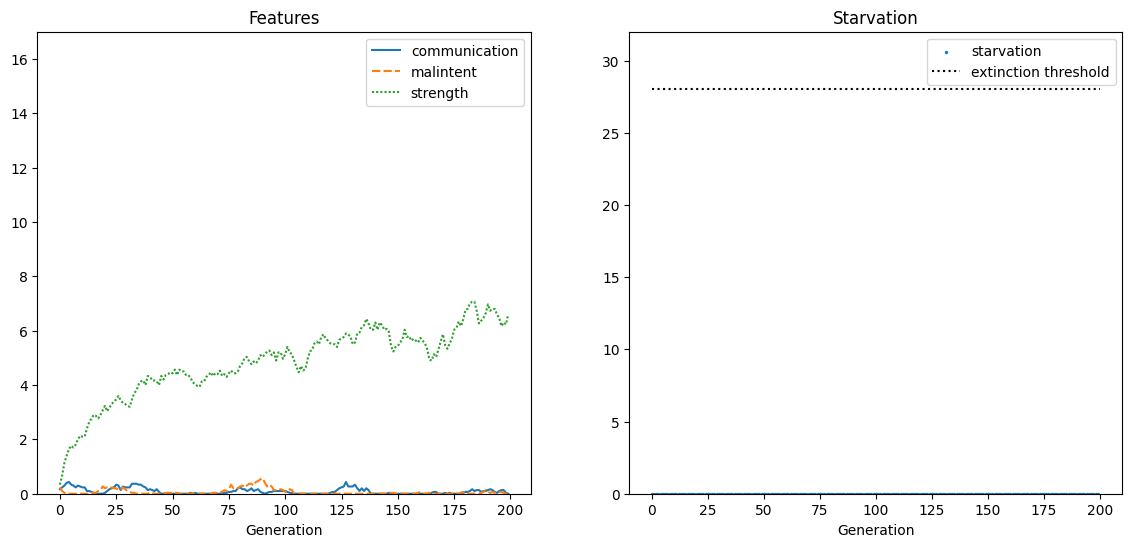

In [34]:
sim_reputation = simulate_generation(num_food_opportunities=30, num_generations=200, population_size=30, reputation_reproduction=True)
plot_simulation_stats(sim_reputation)

100%|██████████| 200/200 [08:19<00:00,  2.50s/it]


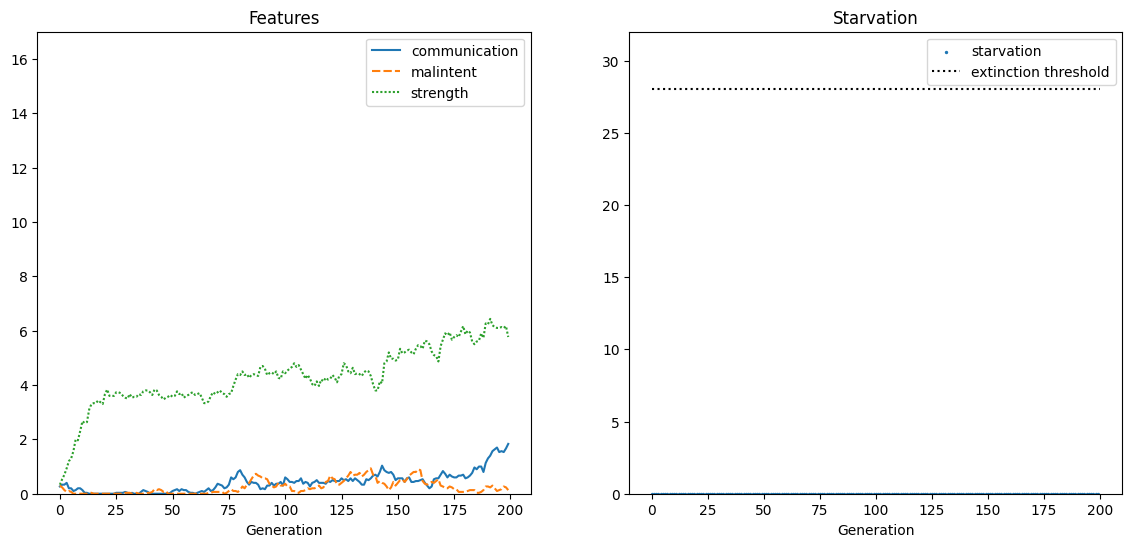

In [35]:
sim_reputation = simulate_generation(num_food_opportunities=30, num_generations=200, population_size=30, reputation_reproduction=True, food_decay=1.7)
plot_simulation_stats(sim_reputation)

100%|██████████| 200/200 [08:54<00:00,  2.67s/it]


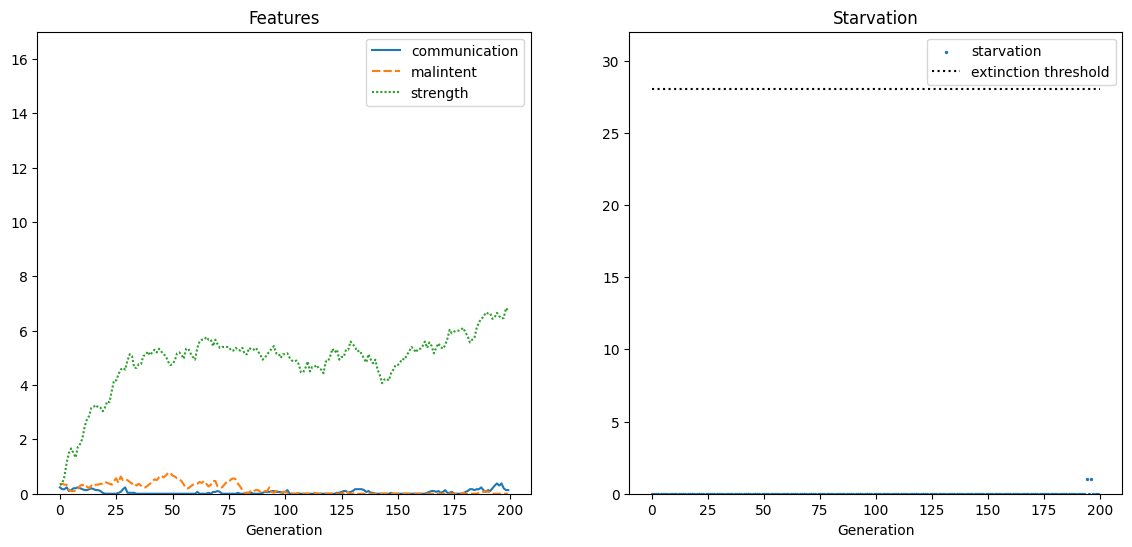

In [36]:
sim_reputation = simulate_generation(num_food_opportunities=50, num_generations=200, population_size=30, reputation_reproduction=True, food_decay=1.7)
plot_simulation_stats(sim_reputation)